In [1]:
import re
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liamw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Cleaning

In [7]:
# Load the data from the comments database, returns the tuple (comments, categories)
def load_data():
    # read in the comments for each video from database
    conn1 = sqlite3.connect("youtubeComments.db")
    c1 = conn1.cursor()
    c1.execute("""select c.videoID, textOriginal,
        l.SelfDirection, l.Stimulation, l.Hedonism,
        l.Achievement, l.Power, l.Security, l.Tradition,
        l.Conformity, l.Benevolence, l.Universalism
        from commentsThreads c join labels l on c.videoID = l.videoID
        order by c.videoID""")
    comments = c1.fetchall()

    # using the fact that comments are ordered by videoID perform a manual group by
    # so that videos[i] contains a giant string of all comments on the video
    video_id = comments[0][0]
    video_comments = [""]
    labels = [comments[0][2:]]
    for comment in comments:
        if video_id != comment[0]:
            video_id = comment[0]
            video_comments.append("")
            labels.append(comment[2:])
        video_comments[-1] += comment[1] + " "

    return video_comments, labels

In [3]:
# a function that performs preprocessing on the text, removing symbols and stopwords
punctuation_re = re.compile('[/(){}\[\]\|@,;]')
non_alphanumeric_re = re.compile('[^0-9a-z #+_]')
stopwords = set(stopwords.words('english'))
def text_prepare(text):
    text = text.lower()
    text = re.sub(punctuation_re, " ", text)
    text = re.sub(non_alphanumeric_re, "", text)

    # delete stopwords from text
    for word in stopwords:
      text = re.sub('(^|\s+)' + word + '($|\s+)', " ", text)

    # clean up whitespace
    text = text.strip()
    text = re.sub('\s+', ' ', text) # transform all multi spaces into one space
    return text

In [4]:
# convert a scikitlearn sparse matrix to a tensorflow sparse tensor
def convert_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.sparse.SparseTensor(indices, coo.data, coo.shape))

In [25]:
# create bag of words dataset using the tfidf method
def create_dataset():
    # load data and perform pre-processing
    X, y = load_data()
    comments = list(map(text_prepare, X))
    
    # split into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    # create and train tfidf vectorizer
    tfidf_vectorizer = TfidfVectorizer(min_df = 2/len(comments),
                                       max_df = 0.9,
                                       ngram_range = (1, 2),
                                       token_pattern = '(\S+)')
    tfidf_vectorizer.fit(X_train) # important to only fit on X_train to avoid data leakage

    # apply the vectorizer and then transform the sparse matrix returned to a tensorflow sparse tensor
    # so that tensorflow models can be used
    X_train = convert_to_sparse_tensor(tfidf_vectorizer.transform(X_train))
    X_test = convert_to_sparse_tensor(tfidf_vectorizer.transform(X_test))
    return X_train, X_test, y_train, y_test, tfidf_vectorizer.vocabulary_

In [26]:
X_train, X_test, y_train, y_test, vocabulary = create_dataset()
# convert labels to be np array to work with tensorflow
y_train = np.asarray(y_train) 
y_test = np.asarray(y_test)

In [64]:
X, y = load_data()

In [65]:
X

['You don\'t know what the curve is, until all this is over. My son used to have a wicked curve. It would be coming straight at a right handed batter and he would think he was going to hit him and then it would break over the plate for a strike. Classic #facts\n Truer words have never been spoken The curve is still exponentially rising with no end in sight. This virus will wipe all of us out. @not alejandro https://amp-theguardian-com.cdn.ampproject.org/v/s/amp.theguardian.com/global-development/2020/mar/26/tokyo-governor-tells-residents-to-stay-home-to-avoid-coronavirus-explosion?amp_js_v=a3&amp_gsa=1&usqp=mq331AQFKAGwASA%3D#aoh=15868328473174&referrer=https%3A%2F%2Fwww.google.com&amp_tf=From%20%251%24s&ampshare=https%3A%2F%2Fwww.theguardian.com%2Fglobal-development%2F2020%2Fmar%2F26%2Ftokyo-governor-tells-residents-to-stay-home-to-avoid-coronavirus-explosion @Mark Hanson as soon as we stop washing are hands and grabbing are balls. I’m so sorry to anyone who has lost someone to this💙 

# Model Creation

In [61]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from sklearn.metrics import accuracy_score

In [84]:
# create a function to plot performance over a models training process
def plot_training(history, y_min, y_max, metric="categorical_accuracy", title="model training"):
    plt.plot(history.history[metric], label="training")
    plt.plot(history.history["val_" + metric], label="validation")
    plt.xticks(range(0, len(history.history[metric]) + 5, 5))
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    plt.gca().set_ylim([y_min, y_max])
    plt.show()

### Simple bag of words model

In [88]:
# build model
X = Input(shape=(X_train.shape[1], ))
dense1 = Dense(100, activation = "relu")(X)
dense2 = Dense(y_train.shape[1], activation = "sigmoid")(dense1) # use sigmoid activation instead of softmax because more than one class can be present
nn = Model(inputs = X, outputs = dense2)
nn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 17329)]           0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1733000   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 1,734,010
Trainable params: 1,734,010
Non-trainable params: 0
_________________________________________________________________


In [89]:
# train model
nn.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['BinaryAccuracy']) # binary cross entropy as again more than one class possible
history = nn.fit(X_train, y_train,
                 batch_size = 32, epochs = 100,
                 validation_data = (X_test, y_test))

Epoch 1/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6924 - binary_accuracy: 0.4886 - val_loss: 0.6818 - val_binary_accuracy: 0.7583
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6729 - binary_accuracy: 0.8659 - val_loss: 0.6686 - val_binary_accuracy: 0.7667
Epoch 3/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6518 - binary_accuracy: 0.8705 - val_loss: 0.6546 - val_binary_accuracy: 0.7750
Epoch 4/100
2/2 [==============================] - 0s 9ms/step - loss: 0.6284 - binary_accuracy: 0.8727 - val_loss: 0.6406 - val_binary_accuracy: 0.7667
Epoch 5/100
2/2 [==============================] - 0s 10ms/step - loss: 0.6045 - binary_accuracy: 0.8682 - val_loss: 0.6268 - val_binary_accuracy: 0.7667
Epoch 6/100
2/2 [==============================] - 0s 9ms/step - loss: 0.5800 - binary_accuracy: 0.8705 - val_loss: 0.6136 - val_binary_accuracy: 0.7750
Epoch 7/100
2/2 [==============================] - 0s 9ms/step - loss: 0.5558 - 

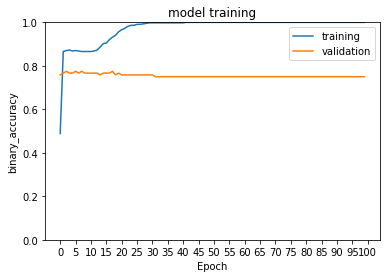

In [90]:
plot_training(history, 0, 1, metric="binary_accuracy")

In [91]:
# measure performance
cutoff = 0.5
train_preds = (nn.predict(X_train) > cutoff).astype(int)
val_preds = (nn.predict(X_test) > cutoff).astype(int)

# get the accuracy of each individual class
for i in range(y_train.shape[1]):
    print("Class {}   Train Accuracy: {}    Test Accuracy: {}".format(i, 
        accuracy_score(y_train[:, i], train_preds[:, i]), accuracy_score(y_test[:, i], val_preds[:, i])))

Class 0   Train Accuracy: 1.0    Test Accuracy: 0.4166666666666667
Class 1   Train Accuracy: 1.0    Test Accuracy: 0.5833333333333334
Class 2   Train Accuracy: 1.0    Test Accuracy: 0.6666666666666666
Class 3   Train Accuracy: 1.0    Test Accuracy: 0.5
Class 4   Train Accuracy: 1.0    Test Accuracy: 0.8333333333333334
Class 5   Train Accuracy: 1.0    Test Accuracy: 0.9166666666666666
Class 6   Train Accuracy: 1.0    Test Accuracy: 0.9166666666666666
Class 7   Train Accuracy: 1.0    Test Accuracy: 0.8333333333333334
Class 8   Train Accuracy: 1.0    Test Accuracy: 0.8333333333333334
Class 9   Train Accuracy: 1.0    Test Accuracy: 1.0


In [92]:
for i in range(y_test.shape[0]):
    print(y_test[i], val_preds[i])

[0 1 0 1 1 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 0 0]
[1 0 0 1 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0] [1 0 0 1 0 0 0 0 0 0]
[1 1 1 1 1 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 0 1 1 0 1 0] [0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 1 0] [0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0] [0 0 1 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]


### LSTM model

In [6]:
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding

First we load and clean the data

In [43]:
X, y = load_data()
X = list(map(text_prepare, X))
y = pd.get_dummies(y) # convert y to one hot vectors

Now transform the words into the pretrained word2vec embeddings obtained from here: https://wikipedia2vec.github.io/wikipedia2vec/pretrained/

In [9]:
# load embeddings, takes a significant amount of time
embedding_file = "enwiki_20180420_win10_100d.txt.bz2"
embedding_size = 100
word_embedder = gensim.models.KeyedVectors.load_word2vec_format(embedding_file, binary=False)

In [10]:
# transform dataset, doesn't take as long but will eat a few gigs of ram
dummy = np.zeros(embedding_size)
X_embedded = []
for video_comments in X:
    X_embedded.append([])
    for word in video_comments.split(" "):
        try:
            embedding = word_embedder.get_vector(word.lower())
        except KeyError: # not in the embeddings
            embedding = dummy
        X_embedded[-1].append(embedding)

In [11]:
print(len(X_embedded), len(X_embedded[2]))
print(len(X), len(X[2].split(" ")))
X_embedded[0][4000]

890 1478
890 1478


array([-0.564 , -0.5716,  0.1391,  0.1087,  0.3961, -0.4121, -0.4644,
       -0.3132, -0.1375,  0.2368, -0.2153, -0.4151, -0.1271,  0.5038,
       -0.2162,  0.032 ,  0.5347, -0.4009, -0.3393, -0.3071, -0.2252,
       -0.221 ,  0.1205,  0.2257, -0.1878,  0.1841,  0.4495, -0.2308,
        0.0757,  0.0752,  0.5288,  0.4406,  0.2842,  0.0872,  0.1878,
       -0.0744,  0.2577,  0.2439,  0.2827, -0.0337, -0.1579, -0.362 ,
       -0.3085,  0.0963,  0.2978,  0.0941,  0.3881, -0.2976, -0.1492,
        0.0589, -0.2725,  0.1134, -0.1209, -0.3495, -0.3261,  1.1247,
        0.968 , -0.1227, -0.4351, -0.3146,  0.3193, -0.3559, -0.2407,
       -0.6482, -0.3129, -0.7203,  0.0791,  0.2891,  0.146 , -0.2042,
       -0.6314, -0.4798, -0.3662, -0.2042, -0.3436,  0.3492,  0.4094,
       -0.0641,  0.0525,  0.0728, -0.4157,  0.4037, -0.5495, -0.053 ,
        0.1594, -0.1299,  0.5141, -0.1742,  0.0404,  0.0076,  0.119 ,
        0.3242, -0.7302,  0.7806, -0.5962, -0.3785, -0.2235, -0.3008,
        0.2354,  0.7

having the same sequence length is necessary for batching, lets examine the number of words in the comment section of each video

Now we need to create our dataset, 3000 words is too much for an LSTM so I'll first try 400

### Create Dataset

Most of the dataset has already been created, we just need to cut off each sample to sample_length

In [110]:
# a function that creates new samples by splitting up the comment sections with more than sample_length words
sample_length = 400
def augment_data(X, y):
    X_aug = []
    y_aug = []
    for i in range(len(X)):
        for j in range(0, len(X[i]), sample_length):
            X_aug.append(X[i][j:min(j + sample_length, len(X[i]))]) # append a slice of sample_length words to X_aug
            y_aug.append(y.iloc[i])
            # pad comments with 0 vectors so each sample has length of sample_length
            length = len(X_aug[-1])
            if length < sample_length:
                X_aug[-1] = np.append(np.array(X_aug[-1]), np.zeros((sample_length - length, embedding_size)), axis = 0)
    return np.array(X_aug), np.array(y_aug)

In [114]:
# need to split data before augmenting to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size = 0.2)
X_train, y_train = augment_data(X_train, y_train)
X_test, y_test = augment_data(X_test, y_test)

In [115]:
X_train.shape, y_train.shape

((5897, 400, 100), (5897, 10))

Create a Bidirectional LSTM which should handle the longer sequences better

In [118]:
model = tf.keras.Sequential()
model.add(Bidirectional(LSTM(100, activation='tanh', dropout=0.2, recurrent_dropout=0.2, input_shape = (None, sample_length, embedding_size))))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['CategoricalAccuracy'])

In [119]:
# train model
history = model.fit(X_train, y_train,
     batch_size = 32, epochs = 50,
     validation_data = (X_test, y_test))

Epoch 1/50
185/185 [==============================] - 842s 5s/step - loss: 2.0404 - categorical_accuracy: 0.2839 - val_loss: 2.0943 - val_categorical_accuracy: 0.2769
Epoch 2/50
185/185 [==============================] - 911s 5s/step - loss: 1.8889 - categorical_accuracy: 0.3519 - val_loss: 2.0387 - val_categorical_accuracy: 0.3057
Epoch 3/50
185/185 [==============================] - 875s 5s/step - loss: 1.9414 - categorical_accuracy: 0.3263 - val_loss: 1.8398 - val_categorical_accuracy: 0.3742
Epoch 4/50
185/185 [==============================] - 837s 5s/step - loss: 2.1662 - categorical_accuracy: 0.2535 - val_loss: 2.2956 - val_categorical_accuracy: 0.1624
Epoch 5/50
185/185 [==============================] - 845s 5s/step - loss: 2.1397 - categorical_accuracy: 0.2388 - val_loss: 2.1348 - val_categorical_accuracy: 0.2481
Epoch 6/50
185/185 [==============================] - 859s 5s/step - loss: 2.0180 - categorical_accuracy: 0.2959 - val_loss: 1.7973 - val_categorical_accuracy: 0.367

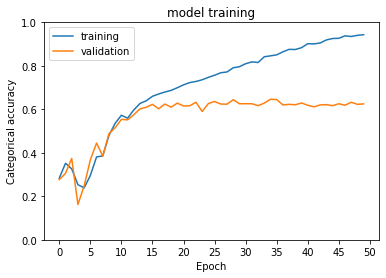

In [122]:
plot_training(history, 0, 1)

### Archive of Dead Code

In [ ]:
# this doesn't work because gensim is an old library and returns a keras layer, not a tf.keras layer, which ruins everything
embedding_layer = word_embedder.get_keras_embedding(train_embeddings=True)
print(type(embedding_layer))
index2entity = word_embedder.index2entity
model = keras.Sequential()
model.add(embedding_layer)
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['CategoricalAccuracy'])

In [ ]:
# this works fine it is just no longer needed
# truncuate (and pad) a sample so that it has length of "length"
def truncate_sample(words, length):
    words = words[:length]
    while len(words) < length:
        words.append(dummy)
    return words

In [12]:
# these functions create a dataset for an LSTM that trains its own embeddings, which isn't our approach anymore
# create a function that creates the LSTM dataset
def lstm_dataset(X_train, X_test, sequence_length, max_words):
    tokenizer = Tokenizer(num_words = max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    X_train = tokenize_text(X_train, tokenizer, sequence_length)
    X_test = tokenize_text(X_test, tokenizer, sequence_length)
    return X_train, X_test
    
# function that tokenizes and pads text
def tokenize_text(text, tokenizer, sequence_length):
    tokens = tokenizer.texts_to_sequences(text)
    tokens = pad_sequences(tokens, maxlen=sequence_length, padding='post', truncating='post')
    return tokens